<a href="https://colab.research.google.com/github/sakasa/notebooks/blob/master/tokyo_covid19_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from pytz import timezone
import numpy as np
import seaborn as sns

%matplotlib inline

### Tokyo COVID19 Data
https://github.com/tokyo-metropolitan-gov/covid19

In [2]:
url = 'https://raw.githubusercontent.com/tokyo-metropolitan-gov/covid19/development/data/data.json'

In [3]:
response = requests.get(url)
print(response)
j_res = json.loads(response.text) # json文字列をdictへ
print(j_res.keys())
j_res['patients_summary']['data'][-15:]

<Response [200]>
dict_keys(['contacts', 'querents', 'patients_summary', 'inspections_summary', 'lastUpdate', 'main_summary'])


[{'小計': 4836, '日付': '2022-03-14T08:00:00.000Z'},
 {'小計': 7836, '日付': '2022-03-15T08:00:00.000Z'},
 {'小計': 10221, '日付': '2022-03-16T08:00:00.000Z'},
 {'小計': 8461, '日付': '2022-03-17T08:00:00.000Z'},
 {'小計': 7825, '日付': '2022-03-18T08:00:00.000Z'},
 {'小計': 7444, '日付': '2022-03-19T08:00:00.000Z'},
 {'小計': 6502, '日付': '2022-03-20T08:00:00.000Z'},
 {'小計': 3855, '日付': '2022-03-21T08:00:00.000Z'},
 {'小計': 3533, '日付': '2022-03-22T08:00:00.000Z'},
 {'小計': 6430, '日付': '2022-03-23T08:00:00.000Z'},
 {'小計': 8875, '日付': '2022-03-24T08:00:00.000Z'},
 {'小計': 7289, '日付': '2022-03-25T08:00:00.000Z'},
 {'小計': 7440, '日付': '2022-03-26T08:00:00.000Z'},
 {'小計': 7844, '日付': '2022-03-27T08:00:00.000Z'},
 {'小計': 4544, '日付': '2022-03-28T08:00:00.000Z'}]

In [4]:
def utc_datestr_to_jst_date(datestr):
  #return datetime.datetime.fromisoformat(datestr.replace('Z', '+00:00')).astimezone(timezone('Asia/Tokyo'))
  # for ~Python3.6
  return datetime.datetime.strptime(datestr.split('.')[0].replace('-', '').replace(':', ''), '%Y%m%dT%H%M%S').astimezone(timezone('Asia/Tokyo'))

In [5]:
keys = ['contacts', 'querents', 'patients_summary']

In [6]:
d = j_res
df = pd.DataFrame()
for key in keys:
  k = f'{key.split("_")[0]}_count'
  for v in d[key].values():
    if type(v) is list:
      index = [_v['日付'] for _v in v]
      tmp_df = pd.DataFrame(_v for _v in v)
      tmp_df.index = [utc_datestr_to_jst_date(dt) for dt in tmp_df['日付']]
      tmp_df[k] = tmp_df['小計']
  df = pd.concat([df, tmp_df[k]], axis=1)
df = df.fillna(0).astype('int64')
df.index = [i for i in df.index]
df['datetime'] = df.index
df

,contacts_count,querents_count,patients_count,datetime
2020-01-24 17:00:00+09:00,0,0,1,2020-01-24 17:00:00+09:00
2020-01-25 17:00:00+09:00,0,0,1,2020-01-25 17:00:00+09:00
2020-01-26 17:00:00+09:00,0,0,0,2020-01-26 17:00:00+09:00
2020-01-27 17:00:00+09:00,0,0,0,2020-01-27 17:00:00+09:00
2020-01-28 17:00:00+09:00,0,0,0,2020-01-28 17:00:00+09:00
...,...,...,...,...
2022-03-24 17:00:00+09:00,494,0,8875,2022-03-24 17:00:00+09:00
2022-03-25 17:00:00+09:00,493,0,7289,2022-03-25 17:00:00+09:00
2022-03-26 17:00:00+09:00,666,0,7440,2022-03-26 17:00:00+09:00
2022-03-27 17:00:00+09:00,597,0,7844,2022-03-27 17:00:00+09:00


In [7]:
# 7日移動平均
df1 = df
for key in keys:
  k = key.split('_')[0]
  df1[f'{k}_7d_mov_ave'] = df[f'{k}_count'].rolling('7D').mean()
  # df1[f'{k}_7d_mov_center_ave'] = df[f'{k}_count'].rolling(7, center=True).mean()
  df1[f'{k}_7d_mov_sum'] = df[f'{k}_count'].rolling('7D').sum()
df1.tail()

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum
2022-03-24 17:00:00+09:00,494,0,8875,2022-03-24 17:00:00+09:00,571.714286,4002.0,0.0,0.0,6352.000000,44464.0
2022-03-25 17:00:00+09:00,493,0,7289,2022-03-25 17:00:00+09:00,572.571429,4008.0,0.0,0.0,6275.428571,43928.0
2022-03-26 17:00:00+09:00,666,0,7440,2022-03-26 17:00:00+09:00,573.428571,4014.0,0.0,0.0,6274.857143,43924.0
2022-03-27 17:00:00+09:00,597,0,7844,2022-03-27 17:00:00+09:00,581.571429,4071.0,0.0,0.0,6466.571429,45266.0
2022-03-28 17:00:00+09:00,0,0,4544,2022-03-28 17:00:00+09:00,489.714286,3428.0,0.0,0.0,6565.000000,45955.0


In [8]:
df2 = df1
# 日付が年の何週目かを列にセット `'{yy}w{week nnum}`
df2['week_num'] = [f'\'{d.strftime("%y")}w{d.strftime("%V")}' for d in df1.index]
# 曜日の列をセット
df2['week_day'] = [d.strftime('%a') for d in df1.index]
df2.tail(15)

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum,week_num,week_day
2022-03-14 17:00:00+09:00,726,0,4836,2022-03-14 17:00:00+09:00,681.285714,4769.0,0.0,0.0,8631.857143,60423.0,'22w11,Mon
2022-03-15 17:00:00+09:00,637,0,7836,2022-03-15 17:00:00+09:00,673.000000,4711.0,0.0,0.0,8476.285714,59334.0,'22w11,Tue
2022-03-16 17:00:00+09:00,611,0,10221,2022-03-16 17:00:00+09:00,661.857143,4633.0,0.0,0.0,8390.285714,58732.0,'22w11,Wed
2022-03-17 17:00:00+09:00,516,0,8461,2022-03-17 17:00:00+09:00,646.428571,4525.0,0.0,0.0,8159.000000,57113.0,'22w11,Thu
2022-03-18 17:00:00+09:00,487,0,7825,2022-03-18 17:00:00+09:00,624.714286,4373.0,0.0,0.0,8067.714286,56474.0,'22w11,Fri
2022-03-19 17:00:00+09:00,660,0,7444,2022-03-19 17:00:00+09:00,608.285714,4258.0,0.0,0.0,7822.000000,54754.0,'22w11,Sat
2022-03-20 17:00:00+09:00,540,0,6502,2022-03-20 17:00:00+09:00,596.714286,4177.0,0.0,0.0,7589.285714,53125.0,'22w11,Sun
2022-03-21 17:00:00+09:00,643,0,3855,2022-03-21 17:00:00+09:00,584.857143,4094.0,0.0,0.0,7449.142857,52144.0,'22w12,Mon
2022-03-22 17:00:00+09:00,654,0,3533,2022-03-22 17:00:00+09:00,587.285714,4111.0,0.0,0.0,6834.428571,47841.0,'22w12,Tue
2022-03-23 17:00:00+09:00,524,0,6430,2022-03-23 17:00:00+09:00,574.857143,4024.0,0.0,0.0,6292.857143,44050.0,'22w12,Wed


In [9]:
# 週毎に集計
groupby_week_num = df2.groupby('week_num', as_index=True)

In [10]:
# 集計結果から平均と合計を取得しデータフレームにセット
patients_week_num_df = pd.DataFrame({
    # 'patients_week_num': df2['week_num'].unique(),
    'patients_week_mean': [m for m in groupby_week_num.agg({'patients_count': 'mean'})['patients_count']], 
    'patients_week_sum': [s for s in groupby_week_num.agg({'patients_count': 'sum'})['patients_count']]
  }, index=[d for d in groupby_week_num.agg({'datetime': 'max'})['datetime']])
patients_week_num_df.tail()

,patients_week_mean,patients_week_sum
2022-03-13 17:00:00+09:00,8708.714286,60961
2022-03-20 17:00:00+09:00,7589.285714,53125
2022-03-27 17:00:00+09:00,6466.571429,45266
2022-03-28 17:00:00+09:00,4544.000000,4544
2022-01-02 17:00:00+09:00,80.000000,160


In [11]:
df3 = pd.concat([
                df2,
                patients_week_num_df.loc[:, ['patients_week_mean', 'patients_week_sum']]
                ], axis=1)
df3.tail(15)

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum,week_num,week_day,patients_week_mean,patients_week_sum
2022-03-14 17:00:00+09:00,726,0,4836,2022-03-14 17:00:00+09:00,681.285714,4769.0,0.0,0.0,8631.857143,60423.0,'22w11,Mon,NaN,NaN
2022-03-15 17:00:00+09:00,637,0,7836,2022-03-15 17:00:00+09:00,673.000000,4711.0,0.0,0.0,8476.285714,59334.0,'22w11,Tue,NaN,NaN
2022-03-16 17:00:00+09:00,611,0,10221,2022-03-16 17:00:00+09:00,661.857143,4633.0,0.0,0.0,8390.285714,58732.0,'22w11,Wed,NaN,NaN
2022-03-17 17:00:00+09:00,516,0,8461,2022-03-17 17:00:00+09:00,646.428571,4525.0,0.0,0.0,8159.000000,57113.0,'22w11,Thu,NaN,NaN
2022-03-18 17:00:00+09:00,487,0,7825,2022-03-18 17:00:00+09:00,624.714286,4373.0,0.0,0.0,8067.714286,56474.0,'22w11,Fri,NaN,NaN
2022-03-19 17:00:00+09:00,660,0,7444,2022-03-19 17:00:00+09:00,608.285714,4258.0,0.0,0.0,7822.000000,54754.0,'22w11,Sat,NaN,NaN
2022-03-20 17:00:00+09:00,540,0,6502,2022-03-20 17:00:00+09:00,596.714286,4177.0,0.0,0.0,7589.285714,53125.0,'22w11,Sun,7589.285714,53125.0
2022-03-21 17:00:00+09:00,643,0,3855,2022-03-21 17:00:00+09:00,584.857143,4094.0,0.0,0.0,7449.142857,52144.0,'22w12,Mon,NaN,NaN
2022-03-22 17:00:00+09:00,654,0,3533,2022-03-22 17:00:00+09:00,587.285714,4111.0,0.0,0.0,6834.428571,47841.0,'22w12,Tue,NaN,NaN
2022-03-23 17:00:00+09:00,524,0,6430,2022-03-23 17:00:00+09:00,574.857143,4024.0,0.0,0.0,6292.857143,44050.0,'22w12,Wed,NaN,NaN


### グラフ出力

In [12]:
sns.set()
sns.set_style('whitegrid')

In [13]:
### 日毎の数
x = df3.index
y1_1 = df3['patients_count']
y1_2 = df3['patients_7d_mov_ave']
#y1_3 = df3['patients_7d_mov_center_ave']
# y1_4 = df3['patients_week_mean']

In [14]:
### 週毎の数
# y2_1 = df3['patients_7d_mov_sum']
# y2_2 = df3['patients_week_sum']

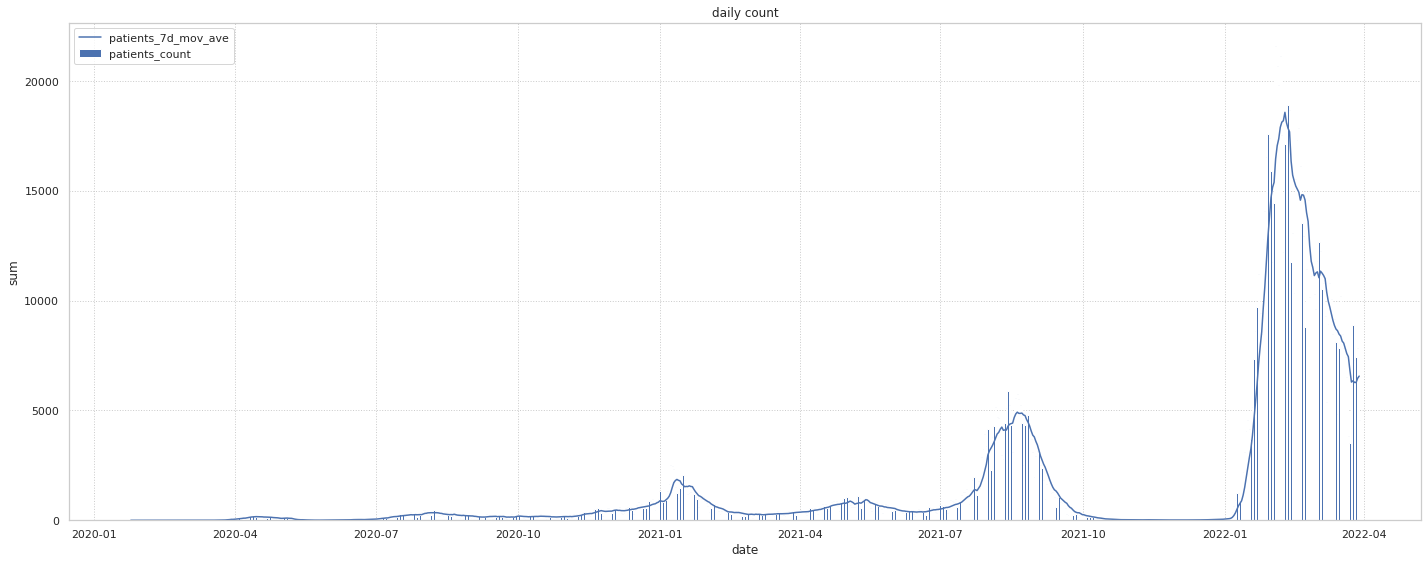

In [15]:
fig, ax = plt.subplots(1,1, figsize=(20, 8))

### 日毎の数
ax.set_title('daily count')
ax.set_xlabel('date')
ax.set_ylabel('sum')
ax.bar(x, y1_1, label='patients_count')
ax.plot(x, y1_2, label='patients_7d_mov_ave')
#ax[0].plot(x, y1_3, label='patients_7d_mov_center_ave')
# ax[0].bar(x, y1_4, label='patients_week_mean')
ax.grid(linestyle=':')
ax.legend()

# ### 週毎の合計
# ax[1].set_title('weekly count')
# ax[1].set_xlabel('date')
# ax[1].set_ylabel('sum')
# ax[1].plot(x, y2_1, label='patients_7d_mov_sum')
# ax[1].bar(x, y2_2, label='patients_week_sum')
# ax[1].grid(linestyle=':')
# ax[1].legend()

plt.tight_layout()

---

In [16]:
def get_date(d: datetime) -> datetime:
  """時間が入った `datetime` を `%Y-%m-%d 00:00:00` の `datetime` に変換します"""
  return datetime.datetime.strptime(d.strftime('%Y-%m-%d'), '%Y-%m-%d')

In [17]:
em_start = datetime.datetime(2020, 4, 7)
em_end = datetime.datetime(2020, 5, 25)
def em_term() -> list:
  """緊急事態宣言期間の日付のリスト"""
  em_term = []
  for i in range((em_end - em_start).days + 1):
    em_term.append(em_start + datetime.timedelta(i))
  return em_term

In [18]:
def emergency(d: datetime) -> int:
  """緊急事態宣言期間中か"""
  return int(get_date(d) in em_term())

In [19]:
def em_passed(d: datetime) -> int:
  """緊急事態宣言から経過日数"""
  d = get_date(d)
  return (d - em_start).days if em_start < d else 0

In [20]:
ds_df = pd.DataFrame({
    'timestamp': [d.timestamp() for d in df3.index], # タイムスタンプ
    'year': np.array(df3.index.strftime('%Y'), dtype=np.int64), # 年
    'month': np.array(df3.index.strftime('%m'), dtype=np.int64), # 月
    'day': np.array(df3.index.strftime('%d'), dtype=np.int64), # 日
    'week_day': df3['week_day'], # 曜日
})
# 曜日をダミー変数化
ds_df = pd.concat([ds_df, pd.get_dummies(ds_df['week_day'])], axis=1)
ds_df = ds_df.drop(columns=['week_day'])

# 経過日数
# ds_df['passed'] = [(d - df3['datetime'][0]).days for d in df3['datetime']]
ds_df['passed'] = [(d - df3.index[0]).days for d in df3.index]
# 緊急事態宣言期間中
ds_df['emergency'] = [emergency(d) for d in df3.index]
# 緊急事態宣言経過日数
ds_df['em_passed'] = [em_passed(d) for d in df3.index]
for key in keys:
  k = key.split('_')[0]
  # 日毎の数
  ds_df[f'{k}_count'] = df3[f'{k}_count']
  # 7日間移動平均
  ds_df[f'{k}_7d_mov_ave'] = df3[f'{k}_7d_mov_ave']
  #ds_df[f'{k}_7d_mov_center_ave'] = df3[f'{k}_7d_mov_center_ave']
  # 7日間移動合計
  ds_df[f'{k}_7d_mov_sum'] = df3[f'{k}_7d_mov_sum']

# 日毎の数
# ds_df['patients_count'] = df3['patients_count']
# 7日間移動平均
# ds_df['patients_7d_mov_ave'] = df3['patients_7d_mov_ave']
#ds_df['7d_mov_center_ave'] = df3['patients_7d_mov_center_ave']
# 7日間移動合計
# ds_df['patients_7d_mov_sum'] = df3['patients_7d_mov_sum']

ds_df = ds_df.reset_index(drop=True)
ds_df.tail(15)

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,...,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
780,1.647245e+09,2022,3,14,0,1,0,0,0,0,...,706,726,681.285714,4769.0,0,0.0,0.0,4836,8631.857143,60423.0
781,1.647331e+09,2022,3,15,0,0,0,0,0,1,...,707,637,673.000000,4711.0,0,0.0,0.0,7836,8476.285714,59334.0
782,1.647418e+09,2022,3,16,0,0,0,0,0,0,...,708,611,661.857143,4633.0,0,0.0,0.0,10221,8390.285714,58732.0
783,1.647504e+09,2022,3,17,0,0,0,0,1,0,...,709,516,646.428571,4525.0,0,0.0,0.0,8461,8159.000000,57113.0
784,1.647590e+09,2022,3,18,1,0,0,0,0,0,...,710,487,624.714286,4373.0,0,0.0,0.0,7825,8067.714286,56474.0
785,1.647677e+09,2022,3,19,0,0,1,0,0,0,...,711,660,608.285714,4258.0,0,0.0,0.0,7444,7822.000000,54754.0
786,1.647763e+09,2022,3,20,0,0,0,1,0,0,...,712,540,596.714286,4177.0,0,0.0,0.0,6502,7589.285714,53125.0
787,1.647850e+09,2022,3,21,0,1,0,0,0,0,...,713,643,584.857143,4094.0,0,0.0,0.0,3855,7449.142857,52144.0
788,1.647936e+09,2022,3,22,0,0,0,0,0,1,...,714,654,587.285714,4111.0,0,0.0,0.0,3533,6834.428571,47841.0
789,1.648022e+09,2022,3,23,0,0,0,0,0,0,...,715,524,574.857143,4024.0,0,0.0,0.0,6430,6292.857143,44050.0


In [21]:
ds_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 795 entries, 0 to 794
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   timestamp            795 non-null    float64
 1   year                 795 non-null    int64  
 2   month                795 non-null    int64  
 3   day                  795 non-null    int64  
 4   Fri                  795 non-null    uint8  
 5   Mon                  795 non-null    uint8  
 6   Sat                  795 non-null    uint8  
 7   Sun                  795 non-null    uint8  
 8   Thu                  795 non-null    uint8  
 9   Tue                  795 non-null    uint8  
 10  Wed                  795 non-null    uint8  
 11  passed               795 non-null    int64  
 12  emergency            795 non-null    int64  
 13  em_passed            795 non-null    int64  
 14  contacts_count       795 non-null    int64  
 15  contacts_7d_mov_ave  795 non-null    flo

In [22]:
ds_df.describe()

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,...,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
count,7.950000e+02,795.000000,795.000000,795.000000,795.000000,795.000000,795.000000,795.000000,795.000000,795.000000,...,795.000000,795.000000,795.000000,795.000000,795.000000,795.000000,795.000000,795.000000,795.000000,795.000000
mean,1.614154e+09,2020.677987,6.181132,15.769811,0.143396,0.143396,0.143396,0.143396,0.142138,0.142138,...,326.490566,687.616352,686.064480,4802.446541,463.545912,463.545912,3244.821384,1541.249057,1515.683073,10609.761006
std,1.984098e+07,0.661618,3.507803,8.804258,0.350697,0.350697,0.350697,0.350697,0.349412,0.349412,...,224.257602,556.175051,544.010252,3808.077819,776.511857,713.937634,4997.563441,3530.263319,3438.544102,24069.817759
min,1.579853e+09,2020.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.597003e+09,2020.000000,3.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,124.500000,330.000000,331.214286,2318.500000,0.000000,0.000000,0.000000,59.000000,59.428571,416.000000
50%,1.614154e+09,2021.000000,6.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,323.000000,517.000000,528.571429,3700.000000,0.000000,0.000000,0.000000,276.000000,287.142857,2010.000000
75%,1.631304e+09,2021.000000,9.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,521.500000,856.500000,874.071429,6118.500000,937.500000,1026.857143,7188.000000,822.500000,773.714286,5416.000000
max,1.648454e+09,2022.000000,12.000000,31.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,720.000000,3277.000000,2723.000000,19061.000000,4060.000000,2574.142857,18019.000000,21576.000000,18575.000000,130025.000000


In [23]:
ds_df.corr()

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,...,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
timestamp,1.000000e+00,0.897873,0.117981,0.004539,-0.002674,0.002674,-0.000891,0.000891,0.001774,-0.001774,...,0.998715,-0.022507,-0.011449,-0.011447,-0.618960,-0.664717,-0.664717,0.513698,0.520307,0.520309
year,8.978732e-01,1.000000,-0.329743,-0.031551,-0.001577,0.003851,0.003851,0.003851,-0.003337,-0.003337,...,0.903457,0.098653,0.109759,0.109760,-0.612499,-0.666182,-0.666182,0.634380,0.638130,0.638131
month,1.179809e-01,-0.329743,1.000000,-0.001177,-0.002712,-0.003736,-0.010902,-0.007831,0.011850,0.004657,...,0.102493,-0.273125,-0.273530,-0.273528,0.055398,0.079358,0.079358,-0.331181,-0.325038,-0.325037
day,4.539270e-03,-0.031551,-0.001177,1.000000,0.006625,0.009480,0.002954,0.012336,-0.005727,-0.011049,...,0.005149,0.015515,0.002892,0.002890,0.004297,-0.006164,-0.006164,-0.008673,-0.013399,-0.013400
Fri,-2.674201e-03,-0.001577,-0.002712,0.006625,1.000000,-0.167401,-0.167401,-0.167401,-0.166543,-0.166543,...,-0.002241,-0.016971,-0.001969,-0.001968,0.024316,-0.000999,-0.000999,0.018197,-0.000603,-0.000604
Mon,2.674201e-03,0.003851,-0.003736,0.009480,-0.167401,1.000000,-0.167401,-0.167401,-0.166543,-0.166543,...,0.002708,0.035273,-0.000778,-0.000777,0.098860,-0.000999,-0.000999,-0.058156,0.002354,0.002354
Sat,-8.914002e-04,0.003851,-0.010902,0.002954,-0.167401,-0.167401,1.000000,-0.167401,-0.166543,-0.166543,...,-0.000591,0.045043,-0.001341,-0.001340,-0.116094,-0.000999,-0.000999,0.013441,0.000507,0.000506
Sun,8.914002e-04,0.003851,-0.007831,0.012336,-0.167401,-0.167401,-0.167401,1.000000,-0.166543,-0.166543,...,0.001058,-0.023770,-0.000778,-0.000777,-0.107034,-0.000999,-0.000999,-0.009853,0.001677,0.001676
Thu,1.773662e-03,-0.003337,0.011850,-0.005727,-0.166543,-0.166543,-0.166543,-0.166543,1.000000,-0.165689,...,0.001343,-0.011832,0.002103,0.002104,0.030448,0.001337,0.001337,0.029013,-0.000109,-0.000109
Tue,-1.773662e-03,-0.003337,0.004657,-0.011049,-0.166543,-0.166543,-0.166543,-0.166543,-0.165689,1.000000,...,-0.001968,-0.015727,0.001140,0.001140,0.041184,0.001337,0.001337,-0.014383,-0.002401,-0.002401


---

In [24]:
ds_df.columns

Index(['timestamp', 'year', 'month', 'day', 'Fri', 'Mon', 'Sat', 'Sun', 'Thu',
       'Tue', 'Wed', 'passed', 'emergency', 'em_passed', 'contacts_count',
       'contacts_7d_mov_ave', 'contacts_7d_mov_sum', 'querents_count',
       'querents_7d_mov_ave', 'querents_7d_mov_sum', 'patients_count',
       'patients_7d_mov_ave', 'patients_7d_mov_sum'],
      dtype='object')

In [25]:
_df = ds_df.copy()
_df = _df.drop(['year', 'month', 'day', 
          'contacts_7d_mov_ave', 'contacts_7d_mov_sum', 
          'querents_7d_mov_ave', 'querents_7d_mov_sum', 
          ], axis=1)
_df

,timestamp,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,querents_count,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
0,1.579853e+09,1,0,0,0,0,0,0,0,0,0,0,0,1,1.000000,1.0
1,1.579939e+09,0,0,1,0,0,0,0,1,0,0,0,0,1,1.000000,2.0
2,1.580026e+09,0,0,0,1,0,0,0,2,0,0,0,0,0,0.666667,2.0
3,1.580112e+09,0,1,0,0,0,0,0,3,0,0,0,0,0,0.500000,2.0
4,1.580198e+09,0,0,0,0,0,1,0,4,0,0,0,0,0,0.400000,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
790,1.648109e+09,0,0,0,0,1,0,0,790,0,716,494,0,8875,6352.000000,44464.0
791,1.648195e+09,1,0,0,0,0,0,0,791,0,717,493,0,7289,6275.428571,43928.0
792,1.648282e+09,0,0,1,0,0,0,0,792,0,718,666,0,7440,6274.857143,43924.0
793,1.648368e+09,0,0,0,1,0,0,0,793,0,719,597,0,7844,6466.571429,45266.0


In [26]:
_df2 = _df[['timestamp', 'passed', 'emergency', 'patients_count', 'patients_7d_mov_ave', 'patients_7d_mov_sum']]
_df2

,timestamp,passed,emergency,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
0,1.579853e+09,0,0,1,1.000000,1.0
1,1.579939e+09,1,0,1,1.000000,2.0
2,1.580026e+09,2,0,0,0.666667,2.0
3,1.580112e+09,3,0,0,0.500000,2.0
4,1.580198e+09,4,0,0,0.400000,2.0
...,...,...,...,...,...,...
790,1.648109e+09,790,0,8875,6352.000000,44464.0
791,1.648195e+09,791,0,7289,6275.428571,43928.0
792,1.648282e+09,792,0,7440,6274.857143,43924.0
793,1.648368e+09,793,0,7844,6466.571429,45266.0


In [27]:
sns.set(style="ticks", color_codes=True)
#sns.pairplot(data=_df)

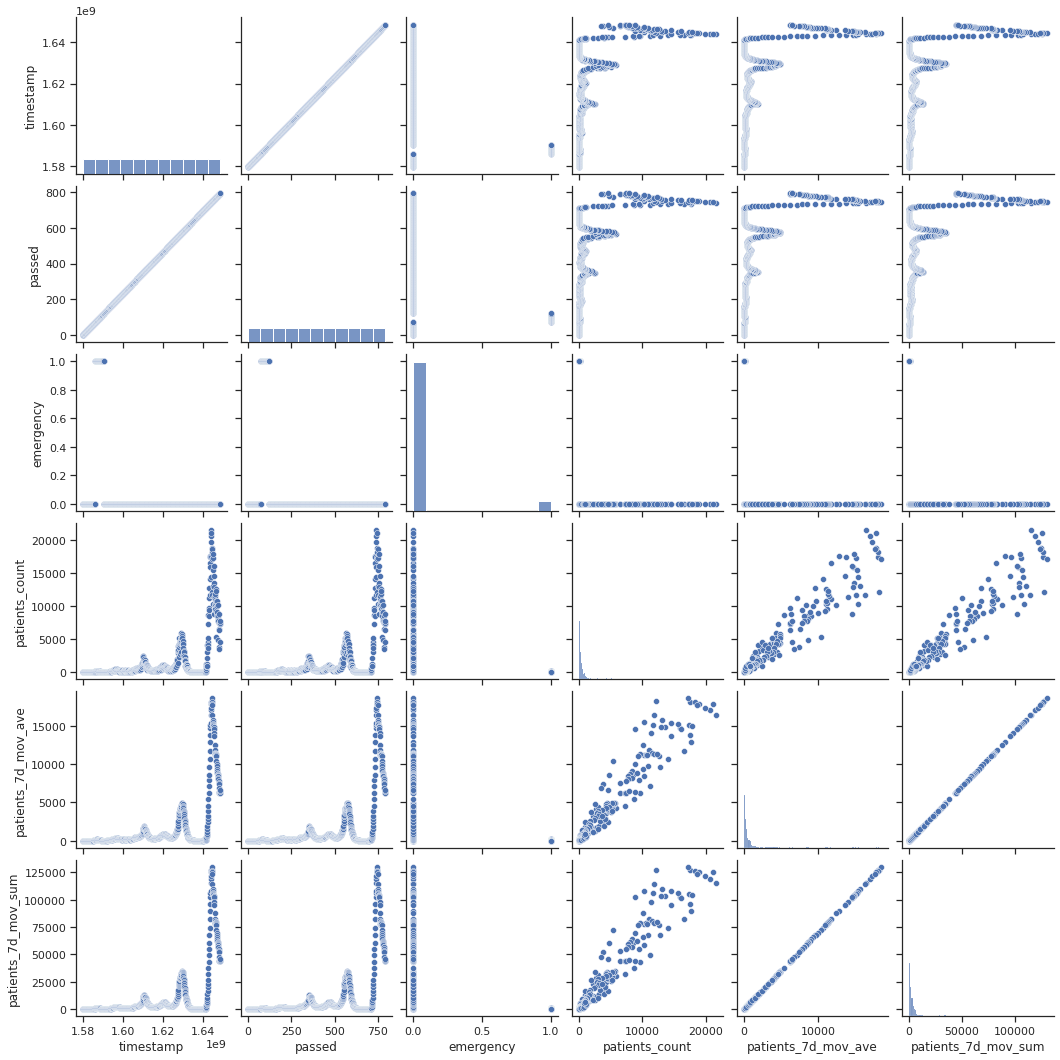

In [28]:
sns.pairplot(data=_df2)

In [29]:
!python -V

Python 3.7.13


In [30]:
!pip freeze

absl-py==1.0.0
alabaster==0.7.12
albumentations==0.1.12
altair==4.2.0
appdirs==1.4.4
argon2-cffi==21.3.0
argon2-cffi-bindings==21.2.0
arviz==0.11.4
astor==0.8.1
astropy==4.3.1
astunparse==1.6.3
atari-py==0.2.9
atomicwrites==1.4.0
attrs==21.4.0
audioread==2.1.9
autograd==1.3
Babel==2.9.1
backcall==0.2.0
beautifulsoup4==4.6.3
bleach==4.1.0
blis==0.4.1
bokeh==2.3.3
Bottleneck==1.3.4
branca==0.4.2
bs4==0.0.1
CacheControl==0.12.10
cached-property==1.5.2
cachetools==4.2.4
catalogue==1.0.0
certifi==2021.10.8
cffi==1.15.0
cftime==1.6.0
chardet==3.0.4
charset-normalizer==2.0.12
click==7.1.2
cloudpickle==1.3.0
cmake==3.12.0
cmdstanpy==0.9.5
colorcet==3.0.0
colorlover==0.3.0
community==1.0.0b1
contextlib2==0.5.5
convertdate==2.4.0
coverage==3.7.1
coveralls==0.5
crcmod==1.7
cufflinks==0.17.3
cvxopt==1.2.7
cvxpy==1.0.31
cycler==0.11.0
cymem==2.0.6
Cython==0.29.28
daft==0.0.4
dask==2.12.0
datascience==0.10.6
debugpy==1.0.0
decorator==4.4.2
defusedxml==0.7.1
descartes==1.1.0
dill==0.3.4
distributed==